# Learning Soft Constraints using Apprenticeship Learning

## General Setup and Imports

Propagate code changes into notebook

In [309]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
%matplotlib inline

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))
from collections import namedtuple, defaultdict


In [312]:
import max_ent.examples.grid_3_by_3 as G
from max_ent.gridworld import Directions
#%matplotlib notebook      commenting this out enables inline plotting
np.random.seed(123)
from max_ent.algorithms import mmp as MMP
from max_ent.algorithms import mmp_helper as H

## Gridworld Setup

The following function sets up the gridworld environment. The gridworld is a 2D grid with a start and goal state. The fig object is also returned now as the last parameter, and if this is saved you can view the images of the world. 

In [313]:
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

In [314]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=2, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal) 
    #test_demo = Demonstration(demo.trajectories[0:2], demo.policy)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)
    return n, n_cfg, demo

### Nominal World

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115059150>}


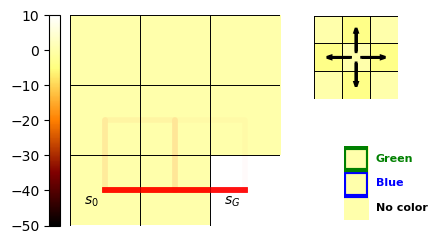

In [315]:
blue = []  # blue states
green = []  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

### Constrained World Creation

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115059150>}


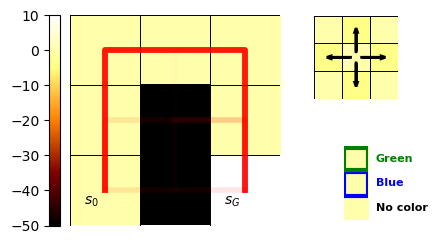

In [316]:
cs = [1, 4]  # constrained states
ca = []  # constrained actions
cc = []  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Algorithm

### Algorithm Specific Imports

In [317]:
import max_ent.optim as O
from max_ent.algorithms import rl as RL
from numpy.linalg import norm
import math
import max_ent.gridworld.trajectory as T
import scipy.special 

### Parameters

In [318]:
discount=0.9
clip_grad_at=10
lr=0.3
max_iter=500
burn_out=200
eps=1e-4
log=None
initial_omega=None
init = O.Constant(1e-6)
optim = O.ExpSga(lr=lr, clip_grad_at=clip_grad_at)
start = [0]
burnout = 500

In [319]:
nominal_rewards = n.reward
world = c.world
terminal = c.terminal
trajectories = demo_c.trajectories
p_transition = world.p_transition
features = world.phi

In [320]:
from collections import namedtuple, defaultdict
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

### Learning

Order of actions:   left, right, up, down, up-left, up-right, down-left, down-right

In [324]:
reward_final, sample_tjs, omega, v_final, fe_current = MMP.mmp(world, nominal_rewards, world.p_transition, world.phi,
                      terminal, trajectories, optim, init, discount,
                      max_iter=max_iter, burnout=200, eps=eps, log=log, initial_omega=initial_omega)

fe_expert:  [0.106812   0.04978297 0.52046553 0.9644418  0.0752311  0.57176048
 0.77954562 0.64983206 0.5979387  0.         1.39895257 1.86412842
 1.05272927 4.31581026 0.         0.        ]
Iteration:  0
Iteration:  1
margin:  3.4513986919760495


In [325]:
reward_final[:,:,2]

array([[-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ],
       [-3.54802956, -2.15667586, -1.70140236, -2.5350725 ]])

In [326]:
omega

array([-1.64257323, -0.88474471,  0.24246781, -0.23374267, -0.54489484,
        0.29194032,  0.11892126,  0.19011741,  0.28029837, -1.60828706,
       -0.21693336,  0.23834014, -0.59533001, -2.1822103 ,  0.        ,
        0.        ])

Expert Feature Expectation:

In [327]:
H.fe_from_trajectories(features, trajectories, discount)

array([0.106812  , 0.04978297, 0.52046553, 0.9644418 , 0.0752311 ,
       0.57176048, 0.77954562, 0.64983206, 0.5979387 , 0.        ,
       1.39895257, 1.86412842, 1.05272927, 4.31581026, 0.        ,
       0.        ])

First 9 are states 0-8, goal state is 2. Next 8 are actions: 

Learned Feature Expectation:

In [328]:
q_new, v_new = H.value_iteration(world.p_transition, learned_params.reward, discount)

Order of actions:   left, right, up, down, up-left, up-right, down-left, down-right

Plotting function to visualize trajectories at any point in algorithm.

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115059150>}


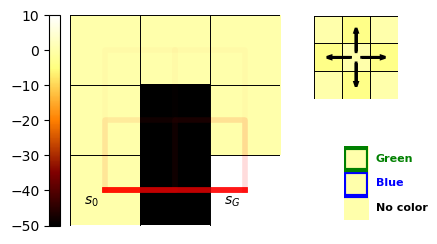

In [341]:
learned_mdp = G.MDP(c.world, reward_final, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, reward_final, c.start, c.terminal)
p = G.plot_world('Learned Constrained', learned_mdp, c_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115059150>}


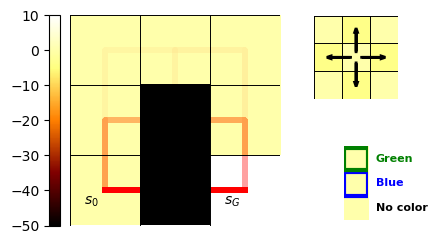

In [342]:
n_cfg = G.config_world(blue, green, cs, ca, cc, 2)
n = n_cfg.mdp


G.plot_world('test', c, c_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           Demonstration(sample_tjs, None), n_cfg.blue, n_cfg.green, vmin=-50, vmax=10);

In [343]:
learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories) 

terminal [2]
e_features [0.13 0.06 1.   1.11 0.11 1.01 1.   0.93 0.96 0.   2.1  2.24 1.97 6.31
 0.   0.  ]
MAE(best):  0.051978974063331
Finished with MAE(best):  0.051978974063331
omega:  [4.80743869e-07 6.35248787e-07 9.99986779e-07 4.36814842e-07
 6.29151771e-07 1.85883303e-06 2.25096442e-06 4.37862351e-06
 2.81726106e-06 1.00000000e-06 3.93917005e-06 2.09996040e-07
 5.23675846e-06 4.33189954e-06 1.00000000e-06 1.00000000e-06]


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115059150>}


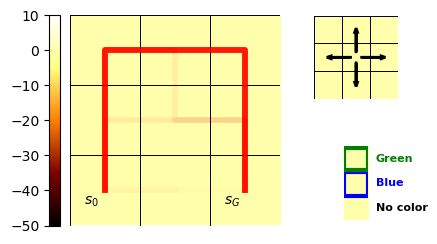

In [339]:
learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
p.savefig('examplemmp.pdf')

In [25]:
q_function, v_function = H.value_iteration(p_transition, learned_params.reward, discount)
policy = H.tochastic_policy_from_q_value(world, q_function) #get policy from running RL with initial reward function
policy_exec = H.stochastic_policy_adapter(policy)
#policy_list.append(policy)

In [26]:
sample_tjs = T.generate_trajectories(1000, world, policy_exec, initial, terminal)

In [28]:
demo_joe = Demonstration(sample_tjs, policy)

In [340]:
p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
              learned_params.action_weights, learned_params.color_weights, 
              demo_joe, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

NameError: name 'demo_joe' is not defined

In [35]:
learned_params.reward[3, 5,:]

array([ -5.6568544 , -14.57849459,   4.34314475,  -5.65685425,
       -30.14219191,  -5.65685425,  -5.65685429,  -5.65685425,
        -5.65685433])